### Python reference implementation of purchase/sale returns

* R - Reserve-Token Balance          (_reserveBalance) 
  * Number of Ether in balance
* S - BET Supply                     (_supply)
  * Number of Tokens in existence
* F - Fixed CRR                      (_reseveRatio)
  * The CRR ratio, ]0-100[. 
* E - reserve token paid/received    (_depositAmount)
  * The amount of reserve token (Ether) either received or paid
* T - BET amount paid/received       (_sellAmount) 
  * The amount of tokens either recie

The `calculatePurchaseReturn` is defined as 

    T = S * ((1 + E/R)^F - 1 )


In [5]:
import math

def calculatePurchaseReturn(S,R,F,E):
    return S * ( math.pow(1.0 + E/R, F/100.0) - 1 )
        
def calculateSaleReturn(S,R,F,T):
    return R * ( math.pow((1.0+T/S)  ,(100.0/F)) -1 )


In [6]:
# These functions mimic the EVM-implementation

PRECISION = 32;  # fractional bits

uint128 = lambda x : int(int(x) & 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF)
uint256 = lambda x : int(int(x) & 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF)          

def return_uint256(func):
    def wrapper(*args, **kwargs):
        return uint256(func(*args, **kwargs))
    return wrapper


@return_uint256
def ln(_numerator, _denominator):
    return fixedLoge(_numerator << PRECISION) - fixedLoge(_denominator << PRECISION);

@return_uint256
def fixedLoge(_x) :
    x = uint256(_x)
    return math.floor((fixedLog2(_x) * 1488522235) >> 31); # 1,488,522,236 = ln(2) * (2 ^ 31)
    

@return_uint256
def fixedLog2( _x) :
    _x = uint256(_x)
    fixedOne = uint256(1 << PRECISION);
    fixedTwo = uint256(2 << PRECISION);

    lo = 0;
    hi = 0;

    while _x < fixedOne:
        _x <<= 1;
        lo += fixedOne;
    

    while _x >= fixedTwo:
        _x >>= 1;
        hi += fixedOne;
    

    for i in range(0, PRECISION,1):
        _x = (_x * _x) >> PRECISION;
        if (_x >= fixedTwo) :
            _x >>= 1;
            hi += uint256(1 << (PRECISION - 1 - i));

    return math.floor(hi - lo);

@return_uint256
def fixedExp( _x) :
    _x = uint256(_x)
    fixedOne = uint256(1 << PRECISION);

    # TODO: change to constant array instead of calculating each time        
    #uint256[34 + 1] memory ni;
    ni = []
    ni.append( 295232799039604140847618609643520000000)
    for n in range( 1,  35,1 ) :
        ni.append(math.floor(ni[n - 1] / n))
        #ni[n] = ;

    res = uint256(ni[0] << PRECISION);
    xi = uint256(fixedOne);
    for i in range(1, 35,1 ):
        xi = uint256((xi * _x) >> PRECISION);
        res += math.floor(xi * ni[i]);
        res = uint256(res)
        
    return math.floor(res / ni[0]);

def power(_baseN,_baseD, _expN, _expD):
    return (fixedExp(ln(_baseN, _baseD) * _expN / _expD), 1 << PRECISION);

@return_uint256
def calculatePurchaseReturnSolidity(S,R,F,E):
    """The 'solidity' version, which matches pretty closely to what 
    happens under the EVM hood"""

    _supply = int(S)
    _reserveBalance = int(R)
    _reserveRatio = int(F)
    _depositAmount = int(E)

    uint128_1 = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
    
    if _supply > uint128_1 or _reserveBalance > uint128_1 or _depositAmount > uint128_1:
        raise Exception("Out of bounds")

    # (E+R)^R
    (resN, resD) = power(uint128(_depositAmount + _reserveBalance), uint128(_reserveBalance), _reserveRatio, 100);
    
    return (_supply * resN / resD) - _supply

        
@return_uint256
def calculateSaleReturnSolidity(S, R, F,  T):
    """The 'solidity' version, which matches pretty closely to what 
    happens under the EVM hood"""
    _supply = int(S)
    _reserveBalance = int(R)
    _reserveRatio = int(F)
    _sellAmount = int(T)
    
    uint128_1 = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
    
    if (_supply == 0 or _reserveBalance == 0 or _reserveRatio < 1 or _reserveRatio > 99 or  _sellAmount == 0):# validate input
            raise Exception("Error %s %s %s" % (_supply, _reserveBalance,_reserveRatio))
        # limiting input to 128bit to provide *some* overflow protection while keeping the interface generic 256bit
        # TODO: will need to revisit this
    if (_supply > uint128_1 or _reserveBalance > uint128_1 or _sellAmount > uint128_1):
        raise Exception("Out of bounds")

    (resN, resD) = power(uint128(_sellAmount + _supply), uint128(_supply), 100, _reserveRatio);
    resN = uint256(resN)
    resD = uint256(resD)
    return (_reserveBalance * resN / resD) - _reserveBalance



In [7]:
class exactCrowdsale():
    
    def __init__(self):
        self.R = 63000.0# 63000 #
        self.S = 300000.0
        self.F = 21 # 21% CRR , 
        
    def __str__(self):
        
        unit_price = self.R / (self.S*self.F)
        return "\n" \
        +" ETH Reserve      %f\n" % self.R \
        +" BGT Supply       %f\n" % self.S \
        +" BGT Market-cap:  %f\n" % (self.S * unit_price)\
        + " BGT Unit price   %f\n" % unit_price 

    def buyWithReserveToken(self, E):
        "This is the exact formula"
        T = calculatePurchaseReturn(self.S,self.R,self.F,E)
        self.R += E
        self.S += T
        return T

    def sellForReserveToken(self, T):
        unit_price = self.R / (self.S*self.F)
        E = calculateSaleReturn(self.S,self.R,self.F,T)
        self.R -= E
        self.S -= T
        return E

class exampleCrowdsale(exactCrowdsale):

    def __init__(self):
        self.R = 63000# 63000 #
        self.S = 300000
        self.F = 21 # 21% CRR , 
                
    def buyWithReserveToken(self, E):
        
        unit_price = self.R / (self.S*self.F)
        
        T_correct = calculatePurchaseReturn(self.S,self.R,self.F,E)
        T = calculatePurchaseReturn2(self.S,self.R,self.F,E)

        #print("ETH received     %f " % E)
        print("BGT Issued       %f (%f, diff %f %%)" % (T, T_correct, (T-T_correct)*100/T))
        
        conversion_rate = E/T
        T = math.floor(T)
        
        self.R += E
        self.S += T
        unit_price_new = self.R / (self.S*self.F)
        return T

    def sellForReserveToken(self, T):

        unit_price = self.R / (self.S*self.F)

        E = calculateSaleReturn2(self.S,self.R,self.F,T)
        E_correct = calculateSaleReturn(self.S,self.R,self.F,T)
        
        #E = math.floor(E)
        self.R -= E
        self.S -= T

        unit_price_new = self.R / (self.S*self.F)

        conversion_rate = E/T
        print("ETH issued     %f (%f, diff %f %%)" % (E, E_correct,(E-E_correct)*100/E))       
        print("BGT received       %f" % -T)
        print("Conversion rate  %f" % conversion_rate)
        
        return E


In [8]:
def generateTestData():
    S = 300000.0
    R = 63000.0
    F= 21

    print("var p = [")
    for i in range(1, 1000,2):
        E = float(i * i) # Goes up to 1 million ether 
        T = calculatePurchaseReturn(S,R,F,E)
        print("\t[%d,%d,%d,%d,%d, %f]," % ( int(S), int(R), int(100*F), int(E),math.floor(T), T ))
    print("];")
    print("module.exports.purchaseReturns = p;")

    print("var s = [")
    for i in range(1, 1000,2):
        T = float(i * i) # Goes up to 1 million tokens 
        E = calculateSaleReturn(S,R,F,T)
        print("\t[%d,%d,%d,%d,%d, %f]," % ( int(S), int(R), int(100*F), int(T),math.floor(E), E ))
    print("];")
    print("module.exports.saleReturns = s;")

generateTestData()

var p = [
	[300000,63000,2100,1,0, 0.999994],
	[300000,63000,2100,9,8, 8.999492],
	[300000,63000,2100,25,24, 24.996082],
	[300000,63000,2100,49,48, 48.984953],
	[300000,63000,2100,81,80, 80.958895],
	[300000,63000,2100,121,120, 120.908308],
	[300000,63000,2100,169,168, 168.821213],
	[300000,63000,2100,225,224, 224.683264],
	[300000,63000,2100,289,288, 288.477765],
	[300000,63000,2100,361,360, 360.185691],
	[300000,63000,2100,441,439, 439.785703],
	[300000,63000,2100,529,527, 527.254181],
	[300000,63000,2100,625,622, 622.565241],
	[300000,63000,2100,729,725, 725.690771],
	[300000,63000,2100,841,836, 836.600456],
	[300000,63000,2100,961,955, 955.261816],
	[300000,63000,2100,1089,1081, 1081.640240],
	[300000,63000,2100,1225,1215, 1215.699019],
	[300000,63000,2100,1369,1357, 1357.399392],
	[300000,63000,2100,1521,1506, 1506.700583],
	[300000,63000,2100,1681,1663, 1663.559848],
	[300000,63000,2100,1849,1827, 1827.932512],
	[300000,63000,2100,2025,1999, 1999.772026],
	[300000,63000,2100,2209

In [9]:
# Random tests

import random, math
def generateRandomTestData():
    print("module.exports.randomPurchaseReturns = [")
    for i in range(1, 100):
        S = float(random.randint(1e6, 3e6))
        F = random.randint(1, 100 )
        R = math.floor(F*S / 100)
        E = float(random.randint(700, 300000))
        T = calculatePurchaseReturn(S,R,float(F),E)
        print("\t[%d,%d,%d,%d,%d, %f]," % ( int(S), int(R), int(F), int(E),math.floor(T), T ))
    print("];")



    print("module.exports.randomSaleReturns = [")
    for i in range(1, 100):
        S = float(random.randint(1e6, 3e6))
        F = random.randint(1, 100 )
        R = math.floor(F*S / 100)
        T = float(random.randint(700, 300000))
        E = calculateSaleReturn(S,R,float(F),T)
        print("\t[%d,%d,%d,%d,%d, %f]," % ( int(S), int(R), int(F), int(T),math.floor(E), E ))
    print("];")



In [10]:
[S,R,F,T] = [2501391,725403,28,291459]
def compareSale(S,R,F,T):    
    E = calculateSaleReturnSolidity(S,R,F,T)
    E_correct = calculateSaleReturn(S,R,F,T)
    if E > E_correct:
        print("Sale returned more Ether than there should be: ")
        print(" [S,R,F,T] = %s" % [S,R,F,T])
        print(" Correct value : %f " % E_correct)
        print(" Returned value: %f " % E)

def comparePurchase(S,R,F,E):    
    T = calculatePurchaseReturnSolidity(S,R,F,E)
    T_correct = calculatePurchaseReturn(S,R,F,E)
    if T > T_correct:
        print("ALERT! Purchase returned more tokens than there should be: ")
        print(" [S,R,F,E] = %s" % [S,R,F,E])
        print(" Correct value : %f " % T_correct)
        print(" Returned value: %f " % T)

compareSale(S,R,F,T)

for F in range(80,90):
    [S,R,F,E] = [300000.0, 63000.0, F, 10000000000.0]
    comparePurchase(S,R,F,E)


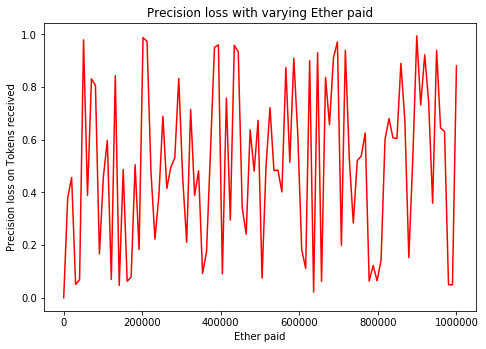

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def getPoints(start, stop,S,R,F,E):    
    _y = []
    _x = []
    steps = 100

    def diff_S(x):
        return calculatePurchaseReturn(x,R,F,E)- calculatePurchaseReturnSolidity(x,R,F,E)
    def diff_R(x):
        return calculatePurchaseReturn(S,x,F,E)- calculatePurchaseReturnSolidity(S,x,F,E)
    def diff_F(x):
        R = int(x * S / 100) 
        delta =  calculatePurchaseReturn(S,R,x,E)- calculatePurchaseReturnSolidity(S,R,x,E)
        if delta < 0:
            print("Delta below 0")
            print("[S,R,F,E]= %s" % [S,R,x,E])
            print("calculatePurchaseReturn(S,R,F,E)= %f" % (calculatePurchaseReturn(S,R,x,E)))
            print("calculatePurchaseReturnSolidity(S,R,F,E)= %f" % (calculatePurchaseReturnSolidity(S,R,x,E)))
        return delta
    def diff_E(x):
        return calculatePurchaseReturn(S,R,F,x)- calculatePurchaseReturnSolidity(S,R,F,x)
    
    diff = diff_S 
    if S is None:
        diff = diff_S
    elif R is None:
        diff = diff_R
    elif F is None:
        diff = diff_F
    elif E is None:
        diff = diff_E
    
    for x in np.linspace(start = start, stop = stop, num=steps):
        x = int(x)
        _y.append(diff(x))
        _x.append(x)        
    return (_x,_y)

S = 300000.0
R = 63000.0
F= 21
E = None

(x,y) = getPoints(0,1000000,S,R,F,E)

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1]) # left, bottom, width, height (range 0 to 1)
axes.plot(x, y, 'r')
axes.set_xlabel('Ether paid')
axes.set_ylabel('Precision loss on Tokens received')
axes.set_title('Precision loss with varying Ether paid');



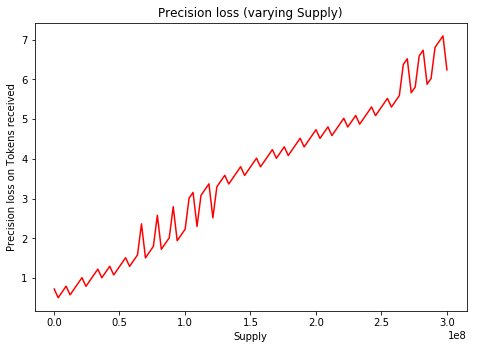

In [12]:
S = None
R = 63000.0
F= 21
E = 1e10

y = []
x = []

(x,y) = getPoints(300000,300000000,S,R,F,E)

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1]) # left, bottom, width, height (range 0 to 1)
axes.plot(x, y, 'r')
axes.set_xlabel('Supply')
axes.set_ylabel('Precision loss on Tokens received')
axes.set_title('Precision loss (varying Supply)');

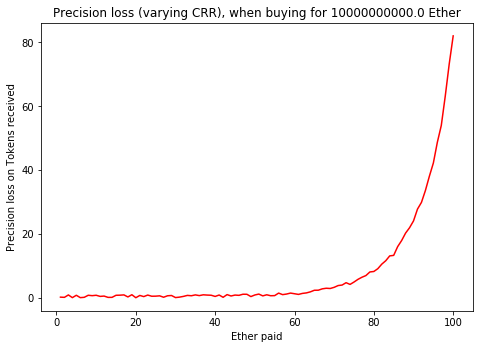

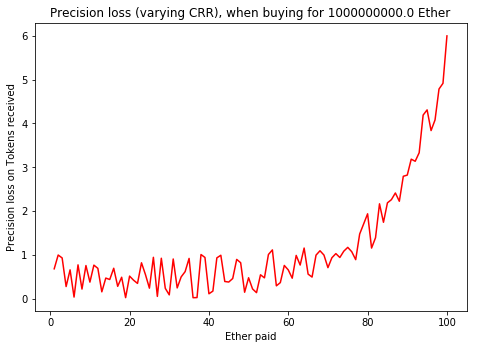

In [13]:
S = 300000.0
R = 63000.0
F= None
E = 1e10

(x,y) = getPoints(1,100,S,R,F,E)

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1]) # left, bottom, width, height (range 0 to 1)
axes.plot(x, y, 'r')
axes.set_xlabel('Ether paid')
axes.set_ylabel('Precision loss on Tokens received')
axes.set_title('Precision loss (varying CRR), when buying for %s Ether' % E);

S = 300000.0
R = 63000.0
F= None
E = 1e9

(x,y) = getPoints(1,100,S,R,F,E)

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1]) # left, bottom, width, height (range 0 to 1)
axes.plot(x, y, 'r')
axes.set_xlabel('Ether paid')
axes.set_ylabel('Precision loss on Tokens received')
axes.set_title('Precision loss (varying CRR)');
axes.set_title('Precision loss (varying CRR), when buying for %s Ether' % E);


The graph above shows that it is possible to gain more tokens than you should be able to receice; when the precision loss is negative, this indicates that the T_Correct < T_Returned . 

In [14]:
def generateTestDataForErrorCases():
    S = 300000.0
    R = 63000.0
    F= None
    E = 1e9
    
    print("module.exports.purchaseReturnsErrors = [")
    for i in range(1, 100,1):
        F = i
        R = int(F * S / 100)
        T_sol = calculatePurchaseReturnSolidity(S,R,F,E)
        T = calculatePurchaseReturn(S,R,F,E)
        if T_sol > T:
            print("\t[%d,%d,%d,%d,%d, %f]," % ( int(S), int(R), int(F), int(E),math.floor(T), T ))
            
    print("];")


generateTestDataForErrorCases()

module.exports.purchaseReturnsErrors = [
];
